## PINNs baseline (by DeepXDE)

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
print("NumPy version:", np.__version__)
# Backend pytorch
import torch
import numpy as np
import datetime, os
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

NumPy version: 2.1.3


### Get data

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
    
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).squeeze()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [4]:
# This function takes in a folder path with the DIB csv files and returns a list of dataframes with data
# from the CSV files
def getCSV(folder_path):
    files = []
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    for file in csv_files:
        file_name = os.path.splitext(file)[0]
        file_path = os.path.join(folder_path, file)
        dataframe = pd.read_csv(file_path, skiprows=range(15))
        files.append(dataframe)
    return files

In [5]:
#This function defines the Cottrell Equation which is Fick's second law of diffusion solved
# for specific boundary conditions for a planar electrode
def Cottrell_eq(t,n,D,F,A,i):
    return i/(n*F*A*(D**(1/2))/((np.pi**(1/2))*t**(1/2)))

def Nernst_eq(E,E0, n, F, R, T):
    #return U+((R*T/(n*F))*np.log((1-x)/x))+V_ni
    #return 1/(1+np.exp(-n*F*(E-E0)/(R*T))) #return x, concentration of reduced species
    return np.exp(E0-E)*(n*F/(R*T)) #return Q, [red]/[ox], = [li+][C6]/[LiC6] at anode

In [6]:
folder_path=r"./Data/DIB/DIB_Data/.csvfiles/Capacity_Check/80per_Cells_Capacity_Check_08122021_080cycle"
files = getCSV(folder_path)

In [7]:
n = 1 #number of electrons transferred per ion
A = 1 #surface area of electrode
D = 2.5*10**(-6) #diffusion coefficient of LiPF6 in EC:DMC, cm^2/s
gas_const = 8.314 #gas constant
T = 25+273.15 #temperature
E0 = 3.7

In [8]:
# Problem parameter
c0 = 1.0 # initial concentration
D = 1.5*10**(-11) # solid-phase diffusion coefficient
R = 1.0
t = 1.0 # time 
It = 1.0 # current at time t
A = 1.0 # battery sheet area
L = 1.0 # thickness of positive/negative electrode
eps = 0.5 # solid phase volume fraction of each electrode
a = 3*eps/R # specific interfacial area
F = 96485 #Faraday's constant, C/mol
delta = It*R/(A*L*F*D*a*c0)

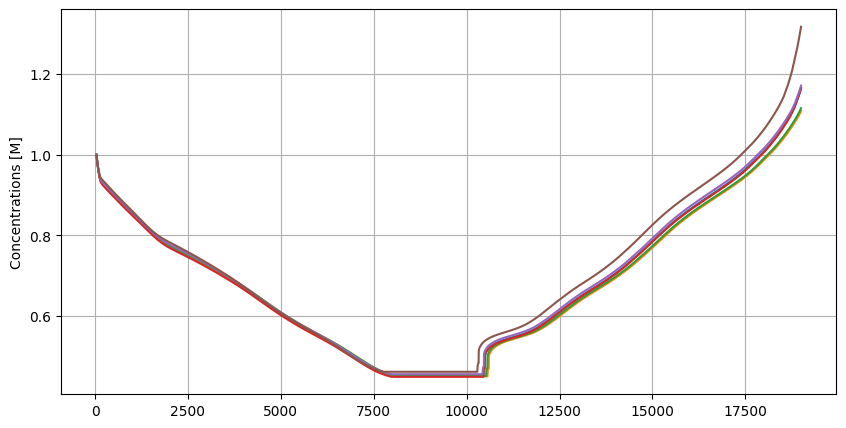

In [9]:
# Calculating total concentration in electrode using Nernst equation
fig2 = plt.figure(figsize=(10, 5))
Q=[]
li_conc=[]
for i in range(len(files)):
    Q.append(Nernst_eq(files[i].iloc[40:19000,7].astype(float), E0, n, F, gas_const,T))
    lic6_conc = Q[i].iloc[0]
    c6_conc = 1
    li_conc.append(Q[i]*c6_conc/lic6_conc)
    plt.plot(li_conc[i])


plt.ylabel('Concentrations [M]')
plt.grid()

In [10]:
Q=[]
li_conc=[]
time = []
for i in range(len(files)):
    Q.append(Nernst_eq(files[i].iloc[40:19000,7].astype(float), E0, n, F, R,T))
    lic6_conc = Q[i].iloc[0]
    c6_conc = 1
    li_conc.append(Q[i]*c6_conc/lic6_conc)
    time.append(files[i].iloc[40:19000,3].astype(float))

combined = list(zip(time, li_conc))
combined0 = np.array(combined[0])

time = np.array(time)
li_conc = np.array(li_conc)

time0 = time[0]
time0 = time0[::10]
li_conc0 = li_conc[0]
li_conc0 = li_conc0[::10]

In [11]:
tau0 = D * time0 / (R**2)
tau_max = np.max(tau0)

In [12]:
tau_max

np.float64(3.6246172500000004e-07)

### PINNs model

In [13]:
# xt = (x, t)
def pde(xt, c):
    # Most backends
    dc_x = dde.grad.jacobian(c, xt, j=0)
    dc_t = dde.grad.jacobian(c, xt, j=1)
    dc_xx = dde.grad.hessian(c, xt, j=0)
    # Backend pytorch
    return (
        dc_t
        - 2 * dc_x / (xt[:, 0] + 1e-6)
        - dc_xx
    )

def boundary_l(xt, on_boundary):
    return on_boundary and dde.utils.isclose(xt[0], 0)

def boundary_r(xt, on_boundary):
    return on_boundary and dde.utils.isclose(xt[0], 1)

In [14]:
# Concentration from dataset
n_obs = time0.shape
observe_xt = np.vstack((np.ones(n_obs), np.array(time0))).T
observe_c = li_conc0.reshape(-1,1)
observe_pts = dde.icbc.PointSetBC(observe_xt, observe_c, component=0)

In [15]:
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc_l = dde.icbc.NeumannBC(geomtime, lambda X: 0.0, boundary_l)
bc_r = dde.icbc.NeumannBC(geomtime, lambda X: 1.0, boundary_r)

ic = dde.icbc.IC(geomtime, lambda X: 1.0, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, ic, observe_pts],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_xt,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000)

Compiling model...
'compile' took 2.664571 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [9.30e+05, 1.58e-03, 1.00e+00, 9.62e-01, 1.12e+00]    [5.09e+06, 1.58e-03, 1.00e+00, 9.62e-01, 1.12e+00]    []  


/home/ycchu97/CS230/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [3.07e+01, 4.03e-08, 1.00e+00, 3.89e-02, 1.58e-01]    [1.78e+02, 4.03e-08, 1.00e+00, 3.89e-02, 1.58e-01]    []  
2000      [2.36e+01, 3.78e-08, 1.00e+00, 3.49e-03, 4.16e-02]    [1.35e+02, 3.78e-08, 1.00e+00, 3.49e-03, 4.16e-02]    []  
3000      [1.60e+01, 2.23e-08, 1.00e+00, 4.00e-03, 3.68e-02]    [9.17e+01, 2.23e-08, 1.00e+00, 4.00e-03, 3.68e-02]    []  
4000      [1.08e+01, 1.97e-08, 1.00e+00, 1.25e-03, 3.35e-02]    [6.02e+01, 1.97e-08, 1.00e+00, 1.25e-03, 3.35e-02]    []  
5000      [7.28e+00, 1.12e-08, 1.00e+00, 6.31e-06, 3.28e-02]    [4.12e+01, 1.12e-08, 1.00e+00, 6.31e-06, 3.28e-02]    []  
6000      [5.01e+00, 7.24e-09, 1.00e+00, 6.60e-04, 3.35e-02]    [2.87e+01, 7.24e-09, 1.00e+00, 6.60e-04, 3.35e-02]    []  
7000      [7.62e+01, 1.11e-07, 1.00e+00, 3.44e-03, 3.91e-02]    [4.35e+02, 1.11e-07, 1.00e+00, 3.44e-03, 3.91e-02]    []  
8000      [2.47e+00, 3.59e-09, 1.00e+00, 9.42e-03, 4.22e-02]    [1.52e+01, 3.59e-09, 1.00e+00, 9.42e-03, 4.22e-02]    []  
9000      [5.71e

Saving loss history to /home/ycchu97/CS230/loss.dat ...
Saving training data to /home/ycchu97/CS230/train.dat ...
Saving test data to /home/ycchu97/CS230/test.dat ...


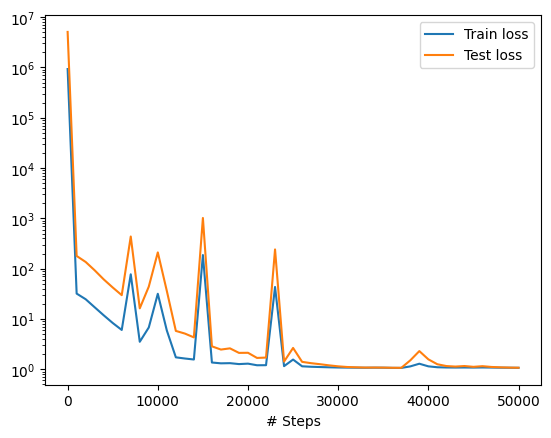

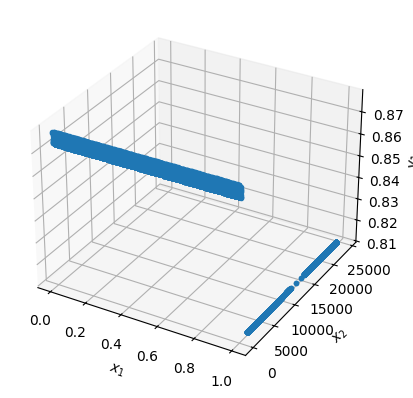

In [16]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

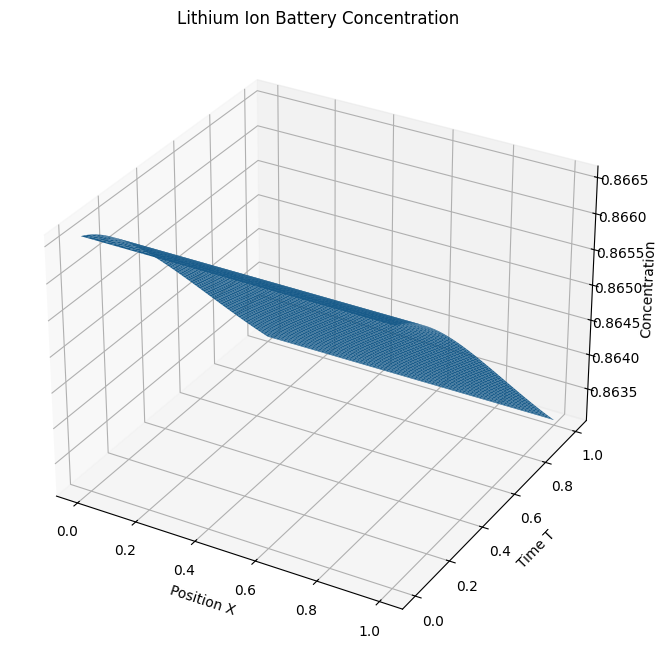

In [17]:
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
points = np.hstack((X_flat, T_flat))
c_pred = model.predict(points)
C_pred = c_pred.reshape(X.shape)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, C_pred)
ax.set_xlabel('Position X')
ax.set_ylabel('Time T')
ax.set_zlabel('Concentration')
ax.set_title('Lithium Ion Battery Concentration')
plt.show()

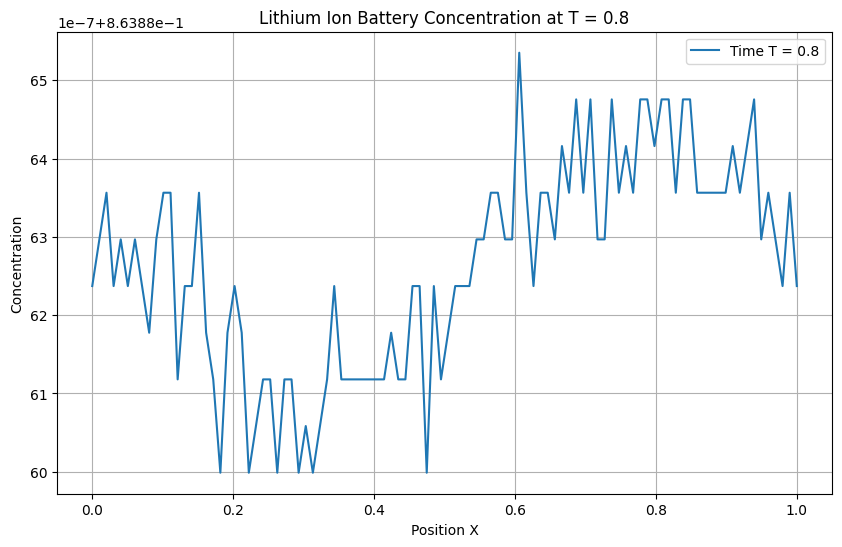

In [18]:
# Extract the data for t = 0.8
fixed_t = 0.8
idx = np.abs(t - fixed_t).argmin()  # Find the closest index for t = 0.8
x_fixed = X[idx, :]
c_fixed = C_pred[idx, :]

# Plot the 2D graph
plt.figure(figsize=(10, 6))
plt.plot(x_fixed, c_fixed, label=f'Time T = {fixed_t}')
plt.xlabel('Position X')
plt.ylabel('Concentration')
plt.title('Lithium Ion Battery Concentration at T = 0.8')
plt.legend()
plt.grid(True)
plt.show()